# Logical order of steps

#### Import, load recordings, preprocess data

In [ ]:
# Import packages

import numpy as np
import os
import pandas as pd
import json
import pickle
from scipy import signal
from scipy.signal import chirp, find_peaks, peak_widths, peak_prominences, hilbert
import ephyviewer
from ephyviewer import mkQApp, MainViewer, TraceViewer
from ephyviewer import AnalogSignalSourceWithScatter
import matplotlib.pyplot as plt
import colorsys

In [28]:
# Import LFP, EMGboolean, (AnalysisInfo DataFrame if existing, otherwise create empty with just ele_nb, cx_name and coords)

EMGboolean = pd.read_pickle(f'EMGframeBoolean.pkl')
All = np.load(f'RawDataChannelExtractedDS.npy', mmap_mode= 'r')     # Downsampled from EXACT sampling frequency to exactly 1000 Hz

analysis_info = {}
spindles_info_prelim = {}
cwt_max_all = {}


###Thoughts: import based on run_key? Do sleep scoring in this script? (no, less flexible, what about SWR/DS etc)


#Get LFPs by calculating differences between electrode pairs (0-based)
nb_E = 11
EMG = All[:,0]
LFPs = {}
for x in range(nb_E):
    LFPs[x] = (All[:, 2*x+1] - All[:, 2*x+2]).astype(np.float32)

#### Detect spindles

In [56]:
# Detect spindles in one Cx based on zscore (peak and sides) -> pick/update threshold

#Pick cortical region to work on (cx_nb/key)
cx_nb = 2   # 4 is S1bf
Ele = LFPs[cx_nb]

# Filter for intuitive displaying later on
# Parameters:
f_lowcut = 12.; f_hicut = 18.; fs = 1000; nyq = 0.5 * fs; N = 4; Wn = [f_lowcut/nyq,f_hicut/nyq]
# Filtering:
b, a = signal.butter(N, Wn, 'band')
filt_Ele = signal.filtfilt(b, a, Ele)

#Parameters for continuous wavelet transform
w = 10.
fs = 1000   #Sampling frequency
freq = np.array((12, 13, 14, 15, 16, 17, 18))
widths = w*fs / (2*freq*np.pi)

#Compute absolute projection of wavelet transform, correct for frequency attenuation, use only max freq at any time
cwt_raw = np.absolute(signal.cwt(Ele, signal.morlet2, widths, w=w))
cwt_raw *= freq[:, np.newaxis]/15   #Divide by 15 (centre freq) to keep gain after correction similar to original
cwt_max = np.max(cwt_raw, axis = 0)

#Exclude wake and REM and keep only SWS to compute mean and std (shortens recording length)
cwt_SWS_mean = np.mean(cwt_max[EMGboolean['BooleanLiberal']])
cwt_SWS_std = np.std(cwt_max[EMGboolean['BooleanLiberal']])

#Put wake and REM to 0 to "exclude" them while keeping original recording length
cwt_max[~EMGboolean['BooleanLiberal']] = 0

C:\Users\Manip1\AppData\Local\Temp\ipykernel_54988\2751644659.py:21: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  cwt_raw = np.absolute(signal.cwt(Ele, signal.morlet2, widths, w=w))


In [30]:
# Visualise and judge automatic spindle detection

# Repeat this and previous cell until satisfied with chosen threshold

In [57]:
#Define thresholds: a higher one for peak, and a lower one to calculate widths
threshold = 1.5   #zscore for detection
th_peak = cwt_SWS_mean + threshold*cwt_SWS_std
th_width = th_peak*0.7
#Will be used for spindle detection criteria: maximum ampli needs to be at least (zscore) and spindle needs to be over (% of minimal max ampli) for given time range

#Find peaks
peaks, peak_heights = find_peaks(cwt_max, height=th_peak, prominence=1)

#Use peak_heights to calculate fake prominences so that th_width is always the same
prominences = [(h_peak - th_width) for h_peak in peak_heights["peak_heights"]]
#Create array that mimics the prominences output from find_peaks, but with fake prominences and beginning/end of recording instead of left_ips/right_ips
fake_prominences = (np.array(prominences), np.ones_like(prominences, dtype=np.int64), np.full_like(prominences, len(cwt_max)-1, dtype=np.int64))
#Compute width data that calculates width at th_width (our specified second threshold)
results_width = peak_widths(cwt_max, peaks, rel_height=1, prominence_data=fake_prominences)

#Rearrange results into dataframe
keys = ["results_width", "width_heights", "left_ips", "right_ips"]
results_width = pd.DataFrame({key: value for key, value in zip(keys, results_width)})

#Create combined dataframe with all the useful info
spindles_info_raw = pd.concat((pd.DataFrame(peaks, columns=['peaks']), results_width["left_ips"], results_width["right_ips"], results_width["results_width"], pd.DataFrame(peak_heights["peak_heights"], columns=['peak_heights'])), axis=1)

#Merge/remove overlapping spindles, keep only peak time and height of higher peak
spindles_info_merged = spindles_info_raw.loc[spindles_info_raw.groupby(['left_ips', 'right_ips'])['peak_heights'].idxmax()]

#Keep only spindles with width of 0.5 - 2 seconds
min_width = 500
max_width = 2000
spindles_info_merged_clean = spindles_info_merged[(spindles_info_merged["results_width"] >= min_width) & (spindles_info_merged["results_width"] <= max_width)]

# Reset index for clean output
spindles_info = spindles_info_merged_clean.reset_index(drop=True)

In [ ]:
### LOOK AT THE RESULT AND JUDGE IT; UPDATE THRESHOLD AND REPEAT IF NECESSARY ###
app = mkQApp()

sample_rate = 1000.
t_start = 0.

combined = np.stack((cwt_max, filt_Ele, Ele, All[:,2*cx_nb+1], All[:,2*cx_nb+2]), axis = 1)
combined = np.concatenate([combined, np.transpose(cwt_raw)], axis=1)    #separate step because cwt_raw different shape on one axis

#create 3 family scatters
scatter_indexes = {0: spindles_info["peaks"], 1: np.array((spindles_info["left_ips"]), dtype=np.int64), 2: np.array((spindles_info["right_ips"]), dtype=np.int64)}
#and assign them to some channels each
scatter_channels = {0: [0, 2], 1: [0, 2], 2: [0, 2]}

source = AnalogSignalSourceWithScatter(combined, sample_rate, t_start, scatter_indexes, scatter_channels)

#Create the main window that can contain several viewers
win = MainViewer(debug=True, show_auto_scale=True)

#create a viewer for signal with TraceViewer connected to the signal source
view1 = TraceViewer(source=source)

view1.params['display_labels'] = True
#Parameters for each channel
view1.by_channel_params['ch0', 'color'] = '#ffffff'
view1.by_channel_params['ch1', 'color'] = '#0055ff'
view1.by_channel_params['ch2', 'color'] = '#ffffff'
view1.by_channel_params['ch3', 'color'] = '#ff5500'
view1.by_channel_params['ch4', 'color'] = '#ff5500'

#Adjust gain based on ampli of data
view1.by_channel_params['ch0', 'gain'] = 2/th_peak
view1.by_channel_params['ch1', 'gain'] = 13/th_peak
view1.by_channel_params['ch2', 'gain'] = 3.3/th_peak
view1.by_channel_params['ch3', 'gain'] = 3.3/th_peak
view1.by_channel_params['ch4', 'gain'] = 3.3/th_peak

view1.by_channel_params['ch0', 'offset'] = 7
view1.by_channel_params['ch1', 'offset'] = 6
view1.by_channel_params['ch2', 'offset'] = -1
view1.by_channel_params['ch3', 'offset'] = -6-32
view1.by_channel_params['ch4', 'offset'] = -9-32

for i in range(5, 12):
    channel = f'ch{i}'
    view1.by_channel_params[channel, 'gain'] = 2/th_peak
    view1.by_channel_params[channel, 'offset'] = 7
    view1.by_channel_params[channel, 'color'] = pastel_colors[i-5]

#put this viewer in the main window
win.add_view(view1)

#Run
win.show()
app.exec()

debug True
QT_MODE PyQt5
refresh duration for  0.0 s
save_all_settings


0

In [58]:
# Update thresholds of this Cx in AnalysisInfo      and update polarity 1 or -1 depending on orientation of spindles
# Save array with spindles times (temporary dict)
data = {
    "cx_nb": cx_nb,
    "polarity": 1,
    "detection_zscore": threshold,
    "threshold_peak": th_peak,
    "threshold_width (in fraction of th_peak)": 0.7,
    "excluded_events": []
}
analysis_info[cx_nb] = pd.DataFrame([data])
spindles_info_prelim[cx_nb] = spindles_info
cwt_max_all[cx_nb] = cwt_max

#### Manual curation of spindles

In [34]:
# Visualise automatically detected spindles in all Cx (ephyviewer)

#Thoughts: plot EMG with sleep score (EMGbool) -> can exclude based on EMG artefacts, or based on pre-REM state
# Plot HP but default out of frame -> can zoom out and see it if relevant/necessary, but doesn't take space on screen by default
# For each Cx, plot: LFP, CWT max, events, (not filt); gain based on mean/zscore
# Use nb of entries in Cx dictionary to define offsets of channels

In [ ]:
hp = [0,1]

nb = len(analysis_info)
def pastel_rainbow(i, N=nb):
    #Generate a pastel rainbow color for step i out of N
    hue = i * (360/nb)/360; saturation = 0.8; value = 1.0  #Colour parameters
    r, g, b = colorsys.hsv_to_rgb(hue, saturation, value)  # Convert HSV to RGB
    r, g, b = int(r * 255), int(g * 255), int(b * 255)  # Convert to 0-255 range
    return f'#{r:02X}{g:02X}{b:02X}'  # Convert to hex

# Generate N pastel rainbow colors
pastel_colors = [pastel_rainbow(i) for i in range(nb)]



app = mkQApp()

sample_rate = 1000.
t_start = 0.

#Generate dataarray "combined" containing EMG (with sleep scoring vector) and LFPs
#And scatter_indexes & scatter_channels to display spindle events

#Sleep scoring vector (0=wake, 1=light sleep, 2=deep sleep, 3=REM)
scatter_indexes = {}; scatter_channels = {}
sleep_scoring = np.zeros(len(EMG)); sleep_scoring[EMGboolean['BooleanLiberal']] = 1; sleep_scoring[EMGboolean['BooleanConservative']] = 2; sleep_scoring[EMGboolean['REMSleep']] = 3
combined = np.stack((EMG, sleep_scoring), axis=1)
print(np.shape(combined))

for i, key in enumerate(sorted(analysis_info)):
    print(i, key)
    combined = np.concatenate([combined, LFPs[key][:, np.newaxis], cwt_max_all[key][:, np.newaxis]], axis=1)
    print(np.shape(combined))

    scatter_indexes[3*i] = spindles_info_prelim[key]["peaks"]
    scatter_indexes[3*i+1] = np.array((spindles_info_prelim[key]["left_ips"]), dtype=np.int32)
    scatter_indexes[3*i+2] = np.array((spindles_info_prelim[key]["right_ips"]), dtype=np.int32)

    scatter_channels.update({3*i: [2*i+2], 3*i+1: [2*i+2], 3*i+2: [2*i+2]})

combined = np.concatenate([combined, LFPs[hp[0]][:, np.newaxis],  LFPs[hp[1]][:, np.newaxis]], axis=1)
print(np.shape(combined))


#create 2 family scatters from theses 2 indexes
# scatter_indexes = {0: spindles_info[0]["peaks"], 1: np.array((spindles_info[0]["left_ips"]), dtype=np.int64), 2: np.array((spindles_info[0]["right_ips"]), dtype=np.int64), 3: spindles_info[1]["peaks"], 4: np.array((spindles_info[1]["left_ips"]), dtype=np.int64), 5: np.array((spindles_info[1]["right_ips"]), dtype=np.int64), 6: spindles_info[2]["peaks"], 7: np.array((spindles_info[2]["left_ips"]), dtype=np.int64), 8: np.array((spindles_info[2]["right_ips"]), dtype=np.int64), 9: spindles_info[3]["peaks"], 10: np.array((spindles_info[3]["left_ips"]), dtype=np.int64), 11: np.array((spindles_info[3]["right_ips"]), dtype=np.int64)}
# #and assign them to some channels each
# scatter_channels = {0: [0], 1: [0], 2: [0], 3: [6], 4: [6], 5: [6], 6: [5], 7: [5], 8: [5], 9: [7], 10: [7], 11: [7]}
source = AnalogSignalSourceWithScatter(combined, sample_rate, t_start, scatter_indexes, scatter_channels)

#Create the main window that can contain several viewers
win = MainViewer(debug=True, show_auto_scale=True)

#create a viewer for signal with TraceViewer
#connected to the signal source
view1 = TraceViewer(source=source)

#Parameters can be set in script
view1.params['display_labels'] = True

#And also parameters for each channel
view1.by_channel_params['ch0', 'color'] = '#ffffff'
view1.by_channel_params['ch1', 'color'] = '#0055ff'

view1.by_channel_params['ch0', 'gain'] = 0.001
view1.by_channel_params['ch1', 'gain'] = 1

view1.by_channel_params['ch0', 'offset'] = -23
view1.by_channel_params['ch1', 'offset'] = 7

channels = np.arange(2, 2*nb+2, 2, dtype=int)
offsets = 8 - ((2*np.arange(nb) + 1)/2) * 18/nb
keys = sorted(analysis_info)

for i, ch, offset, key in zip(range(nb), channels, offsets, keys):
    print(i, ch, offset, key)
    channel = f'ch{ch}'
    view1.by_channel_params[channel, 'gain'] = 12/(nb*analysis_info[key]["threshold_peak"])
    view1.by_channel_params[channel, 'offset'] = offset
    view1.by_channel_params[channel, 'color'] = pastel_colors[i]
    channel = f'ch{ch+1}'
    view1.by_channel_params[channel, 'gain'] = 5/(nb*analysis_info[key]["threshold_peak"])
    view1.by_channel_params[channel, 'offset'] = offset
    view1.by_channel_params[channel, 'color'] = 'white'

view1.by_channel_params[f'ch{ch+2}', 'color'] = 'cyan'
view1.by_channel_params[f'ch{ch+3}', 'color'] = 'cyan'

view1.by_channel_params[f'ch{ch+2}', 'gain'] = 0.01
view1.by_channel_params[f'ch{ch+3}', 'gain'] = 0.01

view1.by_channel_params[f'ch{ch+2}', 'offset'] = -13
view1.by_channel_params[f'ch{ch+3}', 'offset'] = -15

#put this viewer in the main window
win.add_view(view1)

#Run
win.show()
app.exec()

In [ ]:
# Write down events to exclude (with viewer from previous cell open); save list to AnalysisInfo

# Remove flagged events (copy of spindle times array)

# Save clean spindle times in spindles_info dict

# Visualise clean spindles (all Cx, ephyviewer)

In [ ]:
# Check which Cx nb have been analysed/have spindles

for keys in sorted(analysis_info):
    print(keys)

2
3
4
10


In [ ]:
# Use list from previous cell to uncomment relevant lines; fill them in with events to exclude (or leave list empty)

# Go through recording with ephyviewer. When see obviously wrong event, write the approximate timing of them here (can be done in parallel with open ephyviewer)
# Once everything to exclude is written down for all recordings, run next cell

events_toremove = {
    #0: [],
    #1: [],
    2: [],
    3: [],
    4: [],
    #5: [],
    #6: [],
    #7: [],
    #8: [],
    #9: [],
    10: [],
}


In [ ]:
#Run this cell to exclude flagged events
# Will go through the list of flagged events and remove the event in the original list (spindle_info_prelim) that is closest in time to the noted timestamp
def closest(list, Number):
    aux = []
    for valeur in list:
        aux.append(abs(Number*sample_rate-valeur))
    return list[aux.index(min(aux))]

spindles_info_removed = spindles_info_prelim.copy()
for key in sorted(analysis_info):
    print(f"Cx nb {key}")
    print(len(spindles_info_prelim[key]))
    print(len(spindles_info_prelim[key])-len(events_toremove[key]))

    for remove in events_toremove[key]:
        event = closest(spindles_info_removed[key], remove)
        mask = spindles_info_removed[key] != event
        spindles_info_removed[key] = spindles_info_removed[key][mask]

    print(len(spindles_info_removed[key]))   #to check that right number of events was excluded

Cx nb 2
688
688
688
Cx nb 3
792
792
792
Cx nb 4
573
573
573
Cx nb 10
660
660
660


In [ ]:
# Can run this cell to visualise clean spindles. (Same as previous but replaced spindles prelim by removed)
hp = [0,1]

nb = len(analysis_info)
def pastel_rainbow(i, N=nb):
    #Generate a pastel rainbow color for step i out of N
    hue = i * (360/nb)/360; saturation = 0.8; value = 1.0  #Colour parameters
    r, g, b = colorsys.hsv_to_rgb(hue, saturation, value)  # Convert HSV to RGB
    r, g, b = int(r * 255), int(g * 255), int(b * 255)  # Convert to 0-255 range
    return f'#{r:02X}{g:02X}{b:02X}'  # Convert to hex

# Generate N pastel rainbow colors
pastel_colors = [pastel_rainbow(i) for i in range(nb)]



app = mkQApp()

sample_rate = 1000.
t_start = 0.

#Generate dataarray "combined" containing EMG (with sleep scoring vector) and LFPs
#And scatter_indexes & scatter_channels to display spindle events

#Sleep scoring vector (0=wake, 1=light sleep, 2=deep sleep, 3=REM)
scatter_indexes = {}; scatter_channels = {}
sleep_scoring = np.zeros(len(EMG)); sleep_scoring[EMGboolean['BooleanLiberal']] = 1; sleep_scoring[EMGboolean['BooleanConservative']] = 2; sleep_scoring[EMGboolean['REMSleep']] = 3
combined = np.stack((EMG, sleep_scoring), axis=1)
print(np.shape(combined))

for i, key in enumerate(sorted(analysis_info)):
    print(i, key)
    combined = np.concatenate([combined, LFPs[key][:, np.newaxis], cwt_max_all[key][:, np.newaxis]], axis=1)
    print(np.shape(combined))

    scatter_indexes[3*i] = spindles_info_removed[key]["peaks"]
    scatter_indexes[3*i+1] = np.array((spindles_info_removed[key]["left_ips"]), dtype=np.int32)
    scatter_indexes[3*i+2] = np.array((spindles_info_removed[key]["right_ips"]), dtype=np.int32)

    scatter_channels.update({3*i: [2*i+2], 3*i+1: [2*i+2], 3*i+2: [2*i+2]})

combined = np.concatenate([combined, LFPs[hp[0]][:, np.newaxis],  LFPs[hp[1]][:, np.newaxis]], axis=1)
print(np.shape(combined))


#create 2 family scatters from theses 2 indexes
# scatter_indexes = {0: spindles_info[0]["peaks"], 1: np.array((spindles_info[0]["left_ips"]), dtype=np.int64), 2: np.array((spindles_info[0]["right_ips"]), dtype=np.int64), 3: spindles_info[1]["peaks"], 4: np.array((spindles_info[1]["left_ips"]), dtype=np.int64), 5: np.array((spindles_info[1]["right_ips"]), dtype=np.int64), 6: spindles_info[2]["peaks"], 7: np.array((spindles_info[2]["left_ips"]), dtype=np.int64), 8: np.array((spindles_info[2]["right_ips"]), dtype=np.int64), 9: spindles_info[3]["peaks"], 10: np.array((spindles_info[3]["left_ips"]), dtype=np.int64), 11: np.array((spindles_info[3]["right_ips"]), dtype=np.int64)}
# #and assign them to some channels each
# scatter_channels = {0: [0], 1: [0], 2: [0], 3: [6], 4: [6], 5: [6], 6: [5], 7: [5], 8: [5], 9: [7], 10: [7], 11: [7]}
source = AnalogSignalSourceWithScatter(combined, sample_rate, t_start, scatter_indexes, scatter_channels)

#Create the main window that can contain several viewers
win = MainViewer(debug=True, show_auto_scale=True)

#create a viewer for signal with TraceViewer
#connected to the signal source
view1 = TraceViewer(source=source)

#Parameters can be set in script
view1.params['display_labels'] = True

#And also parameters for each channel
view1.by_channel_params['ch0', 'color'] = '#ffffff'
view1.by_channel_params['ch1', 'color'] = '#0055ff'

view1.by_channel_params['ch0', 'gain'] = 0.001
view1.by_channel_params['ch1', 'gain'] = 1

view1.by_channel_params['ch0', 'offset'] = -23
view1.by_channel_params['ch1', 'offset'] = 7

channels = np.arange(2, 2*nb+2, 2, dtype=int)
offsets = 8 - ((2*np.arange(nb) + 1)/2) * 18/nb
keys = sorted(analysis_info)

for i, ch, offset, key in zip(range(nb), channels, offsets, keys):
    print(i, ch, offset, key)
    channel = f'ch{ch}'
    view1.by_channel_params[channel, 'gain'] = 12/(nb*analysis_info[key]["threshold_peak"])
    view1.by_channel_params[channel, 'offset'] = offset
    view1.by_channel_params[channel, 'color'] = pastel_colors[i]
    channel = f'ch{ch+1}'
    view1.by_channel_params[channel, 'gain'] = 5/(nb*analysis_info[key]["threshold_peak"])
    view1.by_channel_params[channel, 'offset'] = offset
    view1.by_channel_params[channel, 'color'] = 'white'

view1.by_channel_params[f'ch{ch+2}', 'color'] = 'cyan'
view1.by_channel_params[f'ch{ch+3}', 'color'] = 'cyan'

view1.by_channel_params[f'ch{ch+2}', 'gain'] = 0.01
view1.by_channel_params[f'ch{ch+3}', 'gain'] = 0.01

view1.by_channel_params[f'ch{ch+2}', 'offset'] = -13
view1.by_channel_params[f'ch{ch+3}', 'offset'] = -15

#put this viewer in the main window
win.add_view(view1)

#Run
win.show()
app.exec()

#### Extraction of spindle features

In [ ]:
# Use phase analysis script, but feed with detected spindle times instead of stimulation times

# Save features as pd.DataFrame in spindles_info dictionary; save spindles_info and AnalysisInfo as pickle

In [ ]:
#Variables that might change from mouse to mouse

# format: recordings = [date_time, TTL of midline, TTL of VB]       #put float("nan") if no stim of this type in recording!!
recordings = [["2024-08-21_16-53-14", 2], ["2024-08-23_13-07-15", 1], ["2024-09-12_14-57-36", 2]]
#recordings = [["2024-08-21_16-53-14", 2]]

stim_regions = ["mid"]    #make sure to have that in same order as TTLs in recordings info
Letter = "F:"
nb_E = 15
mouse = os.path.basename(os.getcwd())   #script contained in folder named after mouse

spindles_info_list = []

for rec_nb, rec_infos in enumerate(recordings):
    print(rec_infos)
    date_time = rec_infos[0]
    if date_time == "2024-09-12_14-57-36":
        recordnode = 112
        acquiboard = 111
    else:
        recordnode = 101
        acquiboard = 100

    ### STIM TIMES ###
    #Load stim info from hard drive with original recording
    sample_numbers = np.load(f"{Letter}/{date_time}/Record Node {recordnode}/experiment1/recording1/events/Acquisition_Board-{acquiboard}.Rhythm Data/TTL/sample_numbers.npy")
    channel_states = np.load(f"{Letter}/{date_time}/Record Node {recordnode}/experiment1/recording1/events/Acquisition_Board-{acquiboard}.Rhythm Data/TTL/states.npy")
    cont = np.load(f"{Letter}/{date_time}/Record Node {recordnode}/experiment1/recording1/continuous/Acquisition_Board-{acquiboard}.Rhythm Data/sample_numbers.npy")

    for pos, stim_region in enumerate(stim_regions):
        TTL = rec_infos[pos+1]  #because loops through mid then vb, and info about TTL is in position 1 and 2 of sub-list in "recordings" (line 4)

        # find the indices of the start and end times
        start_indices = np.where(channel_states == TTL)[0]
        end_indices = np.where(channel_states == -TTL)[0]

        # create a new array with the start and end times
        stim_times = np.column_stack((sample_numbers[start_indices], sample_numbers[end_indices]))

        #Adjust stim timestamps - start time and sampling frequency
        start_time = cont[0]  # in 0.5 milliseconds   #First value of timestamps memmap from 'continuous' folder
        stim_times = ((stim_times - start_time).astype('float64') / 2.0).astype('int64')
        
    del sample_numbers; del channel_states; del cont; del start_indices; del end_indices




    ### LFP RECORDINGS ###
    # Load DS and ordered recordings, and sleep scoring frame, from subfolder
    EMGboolean = pd.read_pickle(f'{date_time}/EMGframeBoolean_1.pkl')
    All = np.load(f'{date_time}/RawDataChannelExtractedDS_1.npy', mmap_mode= 'r')

    #Get LFPs by calculating differences between electrode pairs (0-based)
    #EMG = All[:,0]
    electrodes = {}
    for x in range(nb_E):
        electrodes[x] = (All[:, 2*x+1] - All[:, 2*x+2]).astype(np.float32)   #replaces previous Ea-Eb; stores as float32 (half the memory usage)

    



    sleepstates = ['SWS']
    for sleepstate in sleepstates:
        w = 10.
        fs = 1000   #Sampling frequency
        freq = (np.arange(12, 18.5, 0.5)).astype(np.float32)
        widths = w*fs / (2*freq*np.pi)

        spindles_info_allCX = {}
        nb_E = 15
        for x in range(nb_E):   #finally switch to 0-based indexing
            ############################## UPDATE FOR EACH MOUSE ########################################
            if x in [0,1,3,6,7,10,13, 5,14]:    #6, 15 = CA1 so orientation doesn't matter, no spindles
                pol = 1
            elif x in [2,4,8,9,11,12]:
                pol = -1
            #############################################################################################
            Ele = electrodes[x]*pol

            E_cwt_complex = signal.cwt(Ele, signal.morlet2, widths, w=w)
            E_cwt_phase = (np.angle(E_cwt_complex).astype(np.float32))
            E_cwt_raw = np.absolute(E_cwt_complex)
            E_cwt_raw *= freq[:, np.newaxis]    #Ajuster pour diminution 1/f
            E_cwt_complex = None #Free memory

            CWT_wake0 = E_cwt_raw.copy()
            
            if sleepstate == "SWS":
                BooleanState = EMGboolean['BooleanLiberal']
            elif sleepstate == "REM":
                BooleanState = EMGboolean['REMSleep']
            CWT_wake0[:, ~BooleanState] = 0
            #Compute second mean CWT only for concerned sleep state (not all sleep)
            CWT_wakeremoved2 = E_cwt_raw.copy()
            E_cwt_raw = None
            CWT_wakeremoved2 = CWT_wakeremoved2[:, BooleanState]
            mean_CWT_wakeremoved2 = np.mean(CWT_wakeremoved2, axis=1)

            #Loop through stims and collect relevant data
            spindles_info_oneCX = []

            #all_stim_freq = (2,4,6,8,10,12,14,16,18,20,40,60,90)
            all_stim_freq = [14]
            for stim_freq in all_stim_freq:
                for stim_nb in range(0, len(stim_times), 10):   #every 10th stim because blocks of 10. To be optimised.
                    stim_start = stim_times[stim_nb, 0]
                    stim_end = stim_times[stim_nb+9, 1]
                    stim_len = round((9000/stim_freq)+10)  #same as stim_end-stim_start (IF MATCHING FREQ), just makes sure all stim blocs have the exact same length  ##BE REALLY CAREFUL ABOUT NOT CONFUSING ACTUAL AND CALCULATED STIM LENGTH
                    stim_phase = np.concatenate([np.tile((c := np.linspace(-np.pi, np.pi, round((stim_len - 10)/9), endpoint=False)), 9), c[:stim_len - len(c) * 9]])    #Fake phase vector assuming each stim pulse start is -pi, cycles up to pi[ before start of new pulse
                    itvl = CWT_wake0[:, stim_start:stim_start+stim_len]
                    if stim_freq<30:
                        if round(9000/(stim_end - stim_start-10)) == stim_freq and 0 != np.any(itvl):   
                            raw_spindle = Ele[stim_start:stim_start+stim_len]
                            phase = E_cwt_phase[:, stim_start:stim_start+stim_len]
                            maxfreqsindex = np.argmax(itvl, axis=0)
                            inst_phase = phase[maxfreqsindex, np.arange(len(maxfreqsindex))]    #Audrey's Igor method
                            phase_diff = (inst_phase - stim_phase + np.pi) % (2*np.pi) - np.pi   #Phase wrapped to [-pi,pi]
                            #Calculate circular mean of phase lag
                            unit_vectors = np.exp(1j * phase_diff)   # 1: Project onto unit circle using Euler's formula
                            mean_vector = np.mean(unit_vectors) # 2: Compute mean vector
                            mean_phase_diff = np.angle(mean_vector)  # 3: Get mean phase (angle)
                            vector_strength = np.abs(mean_vector)   # 4: Get magnitude (locking strength)
                            max_ampli = np.max(CWT_wakeremoved2, axis=0)    #instantaneous max amplitude across freqs
                            peak_zscore = (np.max(itvl)-np.mean(max_ampli))/np.std(max_ampli)
                            spindle_zscore = (np.mean(np.max(itvl, axis=0))-np.mean(max_ampli))/np.std(max_ampli)   #zscore of whole duration of spindle
                            mainfreq = freq[np.argmax(np.trapz(itvl, axis=1))]     #AUC method (trapz). Perform on all freqs of itvl, find index for correct freq

                            row = {
                                "raw_spindle": raw_spindle.astype(np.float32),
                                "itvl": itvl.astype(np.float32),
                                "phase": phase.astype(np.float32),
                                "inst_phase": inst_phase.astype(np.float32),
                                "phase_diff": phase_diff.astype(np.float32),
                                "mean_phase_diff": mean_phase_diff.astype(np.float32),
                                "vector_strength": vector_strength.astype(np.float32),
                                "peak_zscore": peak_zscore.astype(np.float32),
                                "spindle_zscore": spindle_zscore.astype(np.float32),
                                "mainfreq": mainfreq.astype(np.float32)
                                }

                            spindles_info_oneCX.append(row)

            spindles_info_oneCX = pd.DataFrame(spindles_info_oneCX) #turn list into dataframe after looping through all spindles
            spindles_info_allCX[x] = spindles_info_oneCX  #add dataframe to dictionary containing all Eles (all recording sites); key is Ele number (0-based index)
        spindles_info_list.append(spindles_info_allCX)  #append dict with info from one recording to list containing all recordings

# Initialize an empty output dictionary (to merge dicts from all recordings into one final dict)
spindles_info = {}

# Assume all dicts have the same site keys
for site in spindles_info_allCX.keys():
    # Collect the DataFrames from each dictionary for this site
    dfs = [d[site] for d in spindles_info_list]
    
    # Concatenate along rows (spindles)
    spindles_info[site] = pd.concat(dfs, ignore_index=True)

with open("Spindles_Phase_Info.pkl", "wb") as f:
    pickle.dump(spindles_info, f)    

# Content bits

In [8]:
### LLOTS OF CHANNELS ###
spindles_info = []
for E_cwt in [E_cwt_sum, E_cwt_max, E_cwt_sum_1f, E_cwt_max_1f]:
    CWT_wake0 = E_cwt.copy()
    BooleanState = EMGboolean['BooleanLiberal']
    CWT_wake0[~BooleanState] = 0
    #Compute second mean CWT only for concerned sleep state
    CWT_wakeremoved2 = E_cwt.copy()
    CWT_wakeremoved2 = CWT_wakeremoved2[BooleanState]
    mean_CWT_wakeremoved2 = np.mean(CWT_wakeremoved2)
    sd_CWT_wakeremoved2 = np.std(CWT_wakeremoved2)



    #Define thresholds: a higher one for peak, and a lower one to calculate widths
    #Will be used for spindle detection criteria: maximum ampli needs to be at least (nb SDs) and spindle needs to be over (other nb SDs) for given time range
    th_peak = mean_CWT_wakeremoved2 + 1.5*sd_CWT_wakeremoved2     #veryyy conservative (1.5 is S1bf)
    th_width = th_peak*0.7

    #Find peaks
    peaks, peak_heights = find_peaks(CWT_wake0, height=th_peak, prominence=1)

    #Use peak_heights to calculate fake prominences so that th_width is always the same
    prominences = [(h_peak - th_width) for h_peak in peak_heights["peak_heights"]]
    #Create array that mimics the prominences output from find_peaks, but with fake prominences and beginning/end of recording instead of left_ips/right_ips
    fake_prominences = (np.array(prominences), np.ones_like(prominences, dtype=np.int64), np.full_like(prominences, len(CWT_wake0)-1, dtype=np.int64))
    #Compute width data that calculates width at th_width (our specified second threshold)
    results_width = peak_widths(CWT_wake0, peaks, rel_height=1, prominence_data=fake_prominences)

    #Rearrange results into dataframe
    keys = ["results_width", "width_heights", "left_ips", "right_ips"]
    results_width = pd.DataFrame({key: value for key, value in zip(keys, results_width)})

    #Create combined dataframe with all the useful info
    spindles_info_raw = pd.concat((pd.DataFrame(peaks, columns=['peaks']), results_width["left_ips"], results_width["right_ips"], results_width["results_width"], pd.DataFrame(peak_heights["peak_heights"], columns=['peak_heights'])), axis=1)

    #Merge/remove overlapping spindles, keep only peak time and height of heigher peak
    spindles_info_merged = spindles_info_raw.loc[spindles_info_raw.groupby(['left_ips', 'right_ips'])['peak_heights'].idxmax()]

    #Keep only spindles with width of 0.5 - 2 seconds
    min_width = 300
    max_width = 2000
    spindles_info_merged_clean = spindles_info_merged[(spindles_info_merged["results_width"] >= min_width) & (spindles_info_merged["results_width"] <= max_width)]

    # Reset index for clean output
    spindles_info.append(spindles_info_merged_clean.reset_index(drop=True))


###LOOK AT IT

app = mkQApp()

sample_rate = 1000.
t_start = 0.

combined = np.stack((E_cwt_sum, filt_Ele, Ele, All[:,2*(x+1)-1], All[:,2*(x+1)], E_cwt_sum_1f, E_cwt_max, E_cwt_max_1f), axis = 1)
#combined = np.stack((All[:,0], All[:,1], All[:,5], All[:,10], All[:,30]), axis = 1)
combined = np.concatenate([combined, np.transpose(E_cwt_raw), np.transpose(E_cwt_1f)], axis=1)

#create 2 family scatters from theses 2 indexes
scatter_indexes = {0: spindles_info[0]["peaks"], 1: np.array((spindles_info[0]["left_ips"]), dtype=np.int64), 2: np.array((spindles_info[0]["right_ips"]), dtype=np.int64), 3: spindles_info[1]["peaks"], 4: np.array((spindles_info[1]["left_ips"]), dtype=np.int64), 5: np.array((spindles_info[1]["right_ips"]), dtype=np.int64), 6: spindles_info[2]["peaks"], 7: np.array((spindles_info[2]["left_ips"]), dtype=np.int64), 8: np.array((spindles_info[2]["right_ips"]), dtype=np.int64), 9: spindles_info[3]["peaks"], 10: np.array((spindles_info[3]["left_ips"]), dtype=np.int64), 11: np.array((spindles_info[3]["right_ips"]), dtype=np.int64)}
#and assign them to some channels each
scatter_channels = {0: [0], 1: [0], 2: [0], 3: [6], 4: [6], 5: [6], 6: [5], 7: [5], 8: [5], 9: [7], 10: [7], 11: [7]}
source = AnalogSignalSourceWithScatter(combined, sample_rate, t_start, scatter_indexes, scatter_channels)

#Create the main window that can contain several viewers
win = MainViewer(debug=True, show_auto_scale=True)

#create a viewer for signal with TraceViewer
#connected to the signal source
view1 = TraceViewer(source=source)

#Parameters can be set in script
view1.params['display_labels'] = True

cx_gain = 0.005 #0.0012 for S1bf
#And also parameters for each channel
view1.by_channel_params['ch0', 'color'] = '#ffffff'
view1.by_channel_params['ch1', 'color'] = '#0055ff'
view1.by_channel_params['ch2', 'color'] = '#ffffff'
view1.by_channel_params['ch3', 'color'] = '#ff5500'
view1.by_channel_params['ch4', 'color'] = '#ff5500'
view1.by_channel_params['ch5', 'color'] = '#ffffff'
view1.by_channel_params['ch6', 'color'] = '#ffffff'
view1.by_channel_params['ch7', 'color'] = '#ffffff'

view1.by_channel_params['ch0', 'gain'] = cx_gain
view1.by_channel_params['ch1', 'gain'] = cx_gain*5
view1.by_channel_params['ch2', 'gain'] = cx_gain
view1.by_channel_params['ch3', 'gain'] = 0.001
view1.by_channel_params['ch4', 'gain'] = 0.001
view1.by_channel_params['ch5', 'gain'] = cx_gain
view1.by_channel_params['ch6', 'gain'] = cx_gain
view1.by_channel_params['ch7', 'gain'] = cx_gain

view1.by_channel_params['ch0', 'offset'] = 7
view1.by_channel_params['ch1', 'offset'] = 6
view1.by_channel_params['ch2', 'offset'] = -1
view1.by_channel_params['ch3', 'offset'] = -6-32
view1.by_channel_params['ch4', 'offset'] = -9-32
view1.by_channel_params['ch5', 'offset'] = -12
view1.by_channel_params['ch6', 'offset'] = 7
view1.by_channel_params['ch7', 'offset'] = -12

for i in range(8, 15):
    channel = f'ch{i}'
    view1.by_channel_params[channel, 'gain'] = cx_gain
    view1.by_channel_params[channel, 'offset'] = 7
    view1.by_channel_params[channel, 'color'] = pastel_colors[i-8]

for i in range(15, 22):
    channel = f'ch{i}'
    view1.by_channel_params[channel, 'gain'] = cx_gain
    view1.by_channel_params[channel, 'offset'] = -12
    view1.by_channel_params[channel, 'color'] = pastel_colors[i-15]

#put this viewer in the main window
win.add_view(view1)

#Run
win.show()
app.exec()

debug True
QT_MODE PyQt5
refresh duration for  0.0 s
save_all_settings


0

In [ ]:
mainfreq = []
phasesss = []
for index, row in spindles_info[3].iterrows():
    spindle = E_cwt_1f[:, int(row["left_ips"]) : int(row["right_ips"])]
    auc = np.trapz(spindle, axis=1)
    mainfreq = np.argmax(auc)+12
    peakfreq = np.argmax(np.max(spindle, axis=1))+12
    maxfreqsindex = np.argmax(spindle, axis=0)
    igorfreq = np.mean(maxfreqsindex)+12

    phase = E_cwt_phase[:, int(row["left_ips"]) : int(row["right_ips"])]
    maxphase = phase[maxfreqsindex, np.arange(len(maxfreqsindex))]
    phasesss.append(maxphase)

    print(mainfreq, peakfreq, igorfreq)




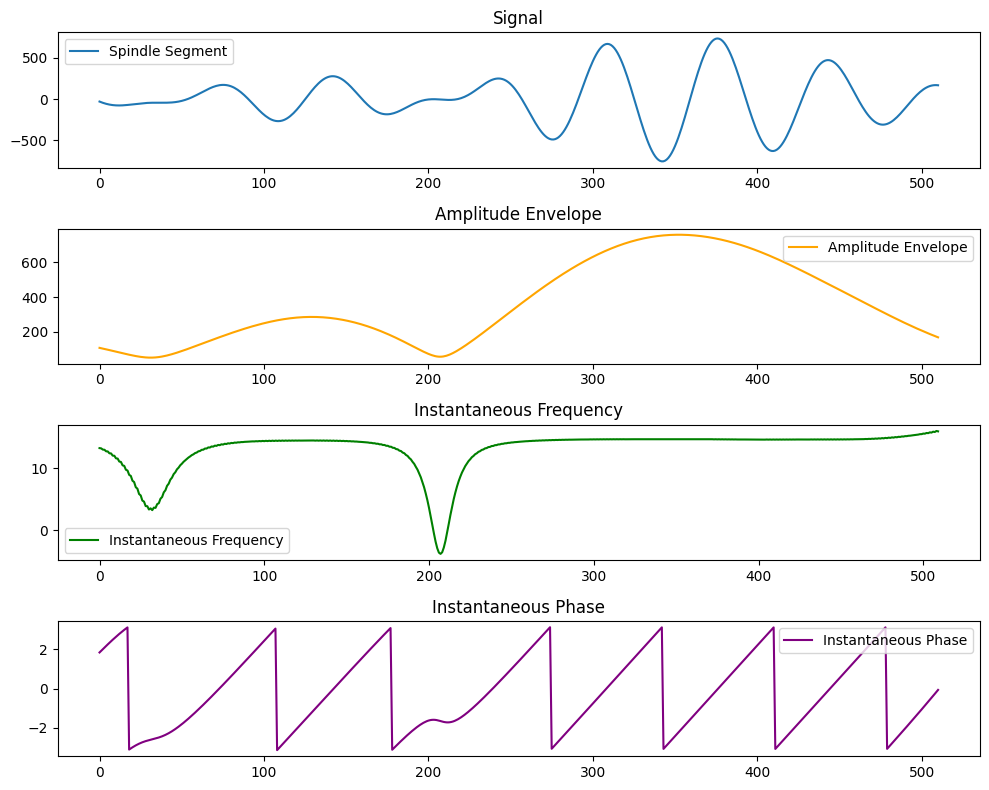

In [13]:
## Look at spindle content with Hilbert transform
# Extract a spindle segment, but add 200ms each side to account for edge artifacts
start = int(spindles_info[3]["left_ips"][5])-200
end = int(spindles_info[3]["right_ips"][5])+200
spindle_segment = filt_Ele[start:end]

# Hilbert transform
analytic_signal = (hilbert(spindle_segment))
instantaneous_amplitude = (np.abs(analytic_signal))
instantaneous_phase = (np.angle(analytic_signal))
instantaneous_frequency = (np.diff(np.unwrap(instantaneous_phase)) * fs / (2 * np.pi))
#Remove extra 200ms on the edges
instantaneous_amplitude = instantaneous_amplitude[200:-200]
instantaneous_phase = instantaneous_phase[200:-200]
instantaneous_frequency =instantaneous_frequency[200:-200]

# Plot results
plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(spindle_segment[200:-200], label="Spindle Segment")
plt.title("Signal")
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(instantaneous_amplitude, label="Amplitude Envelope", color="orange")
plt.title("Amplitude Envelope")
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(instantaneous_frequency, label="Instantaneous Frequency", color="green")
plt.title("Instantaneous Frequency")
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(instantaneous_phase, label="Instantaneous Phase", color="purple")
plt.title("Instantaneous Phase")
plt.legend()

plt.tight_layout()
plt.show()


## Spike times

In [14]:
sorting_analyzer = si.load_sorting_analyzer("sorting_analyzer_training")
sorter_folder = "kilosort4_output"
sorting = si.read_sorter_folder(sorter_folder, register_recording=False)
#sorting.register_recording(raw_rec)
display(sorting)

c:\Users\Manip1\Documents\MB\HayLabAnalysis\.venv-si\Lib\site-packages\spikeinterface\core\base.py:1129: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.101.2 is recommended
  warnings.warn(


KiloSortSortingExtractor: 450 units - 1 segments - 30.0kHz

In [15]:
# KS labels for units
KSlabels = "'mua' 'good' 'good' 'good' 'good' 'good' 'mua' 'mua' 'good' 'mua' 'good' 'mua' 'good' 'good' 'good' 'mua' 'good' 'mua' 'mua' 'good' 'good' 'good' 'mua' 'good' 'mua' 'mua' 'mua' 'mua' 'good' 'mua' 'mua' 'good' 'good' 'mua' 'mua' 'good' 'mua' 'good' 'mua' 'mua' 'mua' 'mua' 'mua' 'good' 'mua' 'good' 'mua' 'mua' 'good' 'mua' 'good' 'good' 'good' 'mua' 'good' 'mua' 'good' 'mua' 'mua' 'mua' 'good' 'good' 'mua' 'good' 'good' 'good' 'good' 'mua' 'good' 'mua' 'mua' 'mua' 'good' 'good' 'good' 'mua' 'mua' 'mua' 'mua' 'good' 'good' 'mua' 'good' 'mua' 'mua' 'good' 'good' 'good' 'good' 'mua' 'good' 'mua' 'mua' 'good' 'mua' 'mua' 'mua' 'mua' 'good' 'mua' 'mua' 'mua' 'mua' 'good' 'mua' 'mua' 'mua' 'good' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'good' 'mua' 'good' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'good' 'mua' 'good' 'good' 'good' 'good' 'good' 'mua' 'mua' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'mua' 'good' 'mua' 'good' 'mua' 'good' 'mua' 'mua' 'good' 'mua' 'mua' 'mua' 'good' 'mua' 'mua' 'good' 'good' 'good' 'good' 'good' 'mua' 'good' 'good' 'good' 'good' 'mua' 'good' 'good' 'mua' 'mua' 'mua' 'good' 'mua' 'good' 'good' 'good' 'mua' 'good' 'good' 'good' 'mua' 'good' 'good' 'good' 'good' 'good' 'mua' 'good' 'good' 'mua' 'good' 'good' 'good' 'good' 'good' 'mua' 'mua' 'mua' 'mua' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'mua' 'good' 'mua' 'mua' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'mua' 'mua' 'good' 'good' 'mua' 'mua' 'good' 'good' 'good' 'good' 'mua' 'mua' 'mua' 'mua' 'good' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'good' 'mua' 'mua' 'good' 'good' 'mua' 'good' 'mua' 'good' 'good' 'good' 'mua' 'good' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'good' 'mua' 'mua' 'good' 'good' 'mua' 'mua' 'mua' 'mua' 'good' 'mua' 'mua' 'mua' 'good' 'mua' 'good' 'mua' 'mua' 'good' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'good' 'mua' 'mua' 'mua' 'mua' 'good' 'mua' 'good' 'good' 'mua' 'mua' 'good' 'good' 'mua' 'good' 'good' 'mua' 'good' 'good' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'good' 'mua' 'mua' 'mua' 'mua' 'mua' 'good' 'mua' 'mua' 'good' 'mua' 'mua' 'mua' 'good' 'good' 'good' 'good' 'good' 'mua' 'mua' 'mua' 'mua' 'good' 'mua' 'mua' 'good' 'mua' 'good' 'good' 'mua' 'mua' 'good' 'mua' 'good' 'mua' 'mua' 'mua' 'mua' 'good' 'good' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'good' 'mua' 'mua' 'mua' 'mua' 'mua' 'good' 'mua' 'mua' 'good' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'good' 'mua' 'good' 'good' 'mua' 'good' 'mua' 'good' 'mua' 'mua' 'good' 'mua' 'good' 'mua' 'mua' 'mua' 'good' 'mua' 'mua' 'mua' 'mua' 'mua' 'good' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'good' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua'"

# Clean and split text
KSlabels = KSlabels.replace("'", "").split()

# Enumerate words and store in an array
KSlabels = np.array([(index, label) for index, label in enumerate(KSlabels)])

#Keep only units in VB (here units 0-297)
KSlabels = KSlabels[:298]

#Get indices of good units
good_units = np.where(KSlabels == "good")[0]

print(KSlabels, good_units)

[['0' 'mua']
 ['1' 'good']
 ['2' 'good']
 ['3' 'good']
 ['4' 'good']
 ['5' 'good']
 ['6' 'mua']
 ['7' 'mua']
 ['8' 'good']
 ['9' 'mua']
 ['10' 'good']
 ['11' 'mua']
 ['12' 'good']
 ['13' 'good']
 ['14' 'good']
 ['15' 'mua']
 ['16' 'good']
 ['17' 'mua']
 ['18' 'mua']
 ['19' 'good']
 ['20' 'good']
 ['21' 'good']
 ['22' 'mua']
 ['23' 'good']
 ['24' 'mua']
 ['25' 'mua']
 ['26' 'mua']
 ['27' 'mua']
 ['28' 'good']
 ['29' 'mua']
 ['30' 'mua']
 ['31' 'good']
 ['32' 'good']
 ['33' 'mua']
 ['34' 'mua']
 ['35' 'good']
 ['36' 'mua']
 ['37' 'good']
 ['38' 'mua']
 ['39' 'mua']
 ['40' 'mua']
 ['41' 'mua']
 ['42' 'mua']
 ['43' 'good']
 ['44' 'mua']
 ['45' 'good']
 ['46' 'mua']
 ['47' 'mua']
 ['48' 'good']
 ['49' 'mua']
 ['50' 'good']
 ['51' 'good']
 ['52' 'good']
 ['53' 'mua']
 ['54' 'good']
 ['55' 'mua']
 ['56' 'good']
 ['57' 'mua']
 ['58' 'mua']
 ['59' 'mua']
 ['60' 'good']
 ['61' 'good']
 ['62' 'mua']
 ['63' 'good']
 ['64' 'good']
 ['65' 'good']
 ['66' 'good']
 ['67' 'mua']
 ['68' 'good']
 ['69' 'm

In [16]:
#Specify delays and exact sampling freq for this recording
lfp_delay = 51.71585053201852 #seconds
npx_real_fs = 30070.232172153934

#Load spikes and json curation data
spikes = np.load("C:/Users/Manip1/Desktop/Tests LFP + spikes Annie/spikes.npy")
spikes = np.array(spikes.tolist())
unit_locations = np.load("C:/Users/Manip1/Desktop/Tests LFP + spikes Annie/unit_locations.npy")

with open("curation_data.json", "r") as f:
    curation_data = json.load(f)

# Extract unit_ids and removed_units, then get list of only good units
unit_ids = set(curation_data["unit_ids"])
removed_units = set(curation_data["removed_units"])
good_units = sorted(unit_ids - removed_units)  # Remove bad units
# Keep only VB units
vb_units = np.where(unit_locations[:, 1] < 1500)[0] #probe inserted into VB to approx 1500 um length

good_vb_units = np.intersect1d(good_units, vb_units)

#Keep only spikes from good units in vb
good_spikes = spikes[np.isin(spikes[:, 1], good_vb_units)]

#Align timestamps of spindles and spikes (account for delay between LFP and NPX)
good_spikes[:, 0] -= int(round(lfp_delay*npx_real_fs))
#Divide timestamps by ~30 (adjust for exact sampling freq) so that they fit with spindle timestamps
good_spikes[:, 0] = good_spikes[:, 0] / (npx_real_fs/1000)

In [17]:
spikes = np.load("sorting_analyzer_training/sorting/spikes.npy")
spikes = np.array(spikes.tolist())

lfp_delay = 51.71585053201852 #seconds
npx_real_fs = 30070.232172153934

#Keep only spikes from good units in VB
good_spikes = spikes[np.isin(spikes[:, 1], good_units)]
#Align timestamps of spindles and spikes (account for delay between LFP and NPX)
good_spikes[:, 0] -= int(round(lfp_delay*npx_real_fs))
#Divide timestamps by ~30 (adjust for exact sampling freq) so that they fit with spindle timestamps
good_spikes[:, 0] = good_spikes[:, 0] / (npx_real_fs/1000)

In [18]:
spindles_info = spindles_info[3]
spindles_info

,peaks,left_ips,right_ips,results_width,peak_heights
0,9605,9.437712e+03,9.795766e+03,358.054517,4485.608981
1,18507,1.826192e+04,1.876866e+04,506.736125,4810.690026
2,22074,2.154234e+04,2.237815e+04,835.808389,8262.446206
3,23761,2.344366e+04,2.417125e+04,727.590091,6861.299970
4,80651,8.042631e+04,8.091591e+04,489.595170,3541.433556
...,...,...,...,...,...
810,6160643,6.160454e+06,6.161152e+06,698.182369,3953.306313
811,6163741,6.163496e+06,6.164057e+06,560.797346,4519.489323
812,6167389,6.166926e+06,6.167821e+06,895.339370,4868.949806
813,6221289,6.220744e+06,6.221667e+06,923.553593,6803.161487


In [19]:
nb = 8

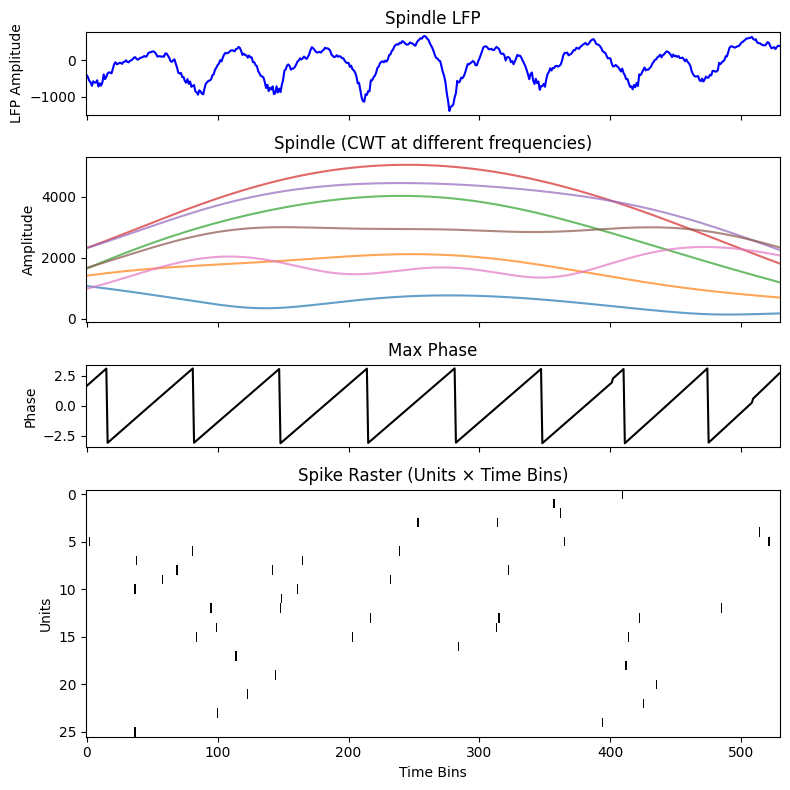

: 

In [ ]:
#Plot a spindle with all the units firing during and around it

#nb = 0
 
row = spindles_info.iloc[nb]
start_time = int(row["left_ips"])
end_time = int(row["right_ips"])
spindle_lfp = Ele[start_time : end_time]
spindle = E_cwt_1f[:, start_time : end_time]
maxfreqsindex = np.argmax(spindle, axis=0)
phase = E_cwt_phase[:, int(row["left_ips"]) : int(row["right_ips"])]
maxphase = phase[maxfreqsindex, np.arange(len(maxfreqsindex))]

bin_size = 1  # Adjust time bin size as needed

# Filter spikes within time range
filtered_spikes = spikes[(spikes[:, 0] >= start_time) & (spikes[:, 0] <= end_time)]

# Define time bins
time_bins = np.arange(start_time, end_time + bin_size, bin_size)

# Get unique units
units = np.unique(filtered_spikes[:, 1])

# Create histogram: Rows are units, columns are time bins
spike_matrix = np.zeros((len(units), len(time_bins)-1))

# Count spikes per unit per time bin
for i, unit in enumerate(units):
    unit_spikes = filtered_spikes[filtered_spikes[:, 1] == unit][:, 0]
    spike_matrix[i], _ = np.histogram(unit_spikes, bins=time_bins)

# Convert to DataFrame for readability
df_spike_matrix = pd.DataFrame(spike_matrix, index=units, columns=time_bins[:-1])




# Create figure and subplots with 4 panels
fig, axs = plt.subplots(4, 1, figsize=(8,8), sharex=True, gridspec_kw={'height_ratios': [1, 2, 1, 3]})

# 1. Spindle LFP (single trace)
axs[0].plot(spindle_lfp, color='blue')
axs[0].set_title("Spindle LFP")
axs[0].set_ylabel("LFP Amplitude")

# 2. Overlayed spindle traces
for trace in spindle:
    axs[1].plot(trace, alpha=0.7)  # Semi-transparent to see all traces
axs[1].set_title("Spindle (CWT at different frequencies)")
axs[1].set_ylabel("Amplitude")

# 3. Maxphase single trace
axs[2].plot(maxphase, color='black')
axs[2].set_title("Max Phase")
axs[2].set_ylabel("Phase")

# 4. Spike raster with imshow (black = high spikes, white = no spikes)
axs[3].imshow(spike_matrix, aspect='auto', cmap='gray_r', interpolation='nearest')
axs[3].set_title("Spike Raster (Units × Time Bins)")
axs[3].set_ylabel("Units")
axs[3].set_xlabel("Time Bins")

# Show plot
plt.tight_layout()
plt.show()

In [106]:
#Create array with info for peri-spindle histogram
psh_spindle = np.zeros((4, 80))
psh_spindle[0] = np.linspace(-2000, 1950, 80)

phase_prefs = np.zeros((len(good_units), 13))
phase_prefs[:,0] = good_units

for _, spindle in spindles_info.iterrows():
    start = int(spindle['left_ips'])
    end = int(spindle['right_ips'])
    width = int(spindle['results_width'])

    closest_index = np.argmin(np.abs(psh_spindle[0] - width))
    psh_spindle[1,40:closest_index+1] += 1

    # Hilbert transform for inst phase (elongate segment to remove edge effect)
    spindle_segment = filt_Ele[start-200:end+200]
    instantaneous_phase = (np.angle(hilbert(spindle_segment)))[200:-200]

    spikes_around_spindle = good_spikes[(good_spikes[:, 0] >= start-2000) & (good_spikes[:, 0] <= start+2000)]
    for ap in spikes_around_spindle:
        ap_time = ap[0]
        closest_index = np.argmin(np.abs(psh_spindle[0] - (ap_time-start)))
        psh_spindle[2,closest_index] += 1

        if end > ap_time >= start :    #meaning action potential happening actually during spindle and not around
            unit_val = ap[1]
            unit_loc = np.where(phase_prefs[:, 0] == unit_val)[0][0]
            phase_val = instantaneous_phase[ap_time-start]  #inst phase at moment of ap
            phase_index = int(np.round(((5.95*(phase_val+np.pi))/np.pi)+0.6))
            phase_prefs[unit_loc, phase_index] += 1
    print(spindle)

peaks            9605.000000
left_ips         9437.711719
right_ips        9795.766236
results_width     358.054517
peak_heights     4485.608981
Name: 0, dtype: float64
peaks            18507.000000
left_ips         18261.919649
right_ips        18768.655774
results_width      506.736125
peak_heights      4810.690026
Name: 1, dtype: float64
peaks            22074.000000
left_ips         21542.342628
right_ips        22378.151017
results_width      835.808389
peak_heights      8262.446206
Name: 2, dtype: float64
peaks            23761.000000
left_ips         23443.662961
right_ips        24171.253053
results_width      727.590091
peak_heights      6861.299970
Name: 3, dtype: float64
peaks            80651.000000
left_ips         80426.310424
right_ips        80915.905595
results_width      489.595170
peak_heights      3541.433556
Name: 4, dtype: float64
peaks            100965.000000
left_ips         100602.831459
right_ips        101113.436396
results_width       510.604936
peak_height

In [107]:
prefs = np.max(phase_prefs[:,1:13], axis=1)/np.mean(phase_prefs[:,1:13], axis=1)

# Compute the mean of the subset
means = np.mean(phase_prefs[:, 1:13], axis=1)

# Apply conditions
mask = (means > 80) & (prefs > 1.2)

# Filter results and keep original indices
filtered_indices = np.where(mask)[0]
filtered_prefs = prefs[mask]
filtered_means = means[mask]

prefs_strong = phase_prefs[filtered_indices]

C:\Users\Manip1\AppData\Local\Temp\ipykernel_8624\1946493703.py:1: RuntimeWarning: invalid value encountered in divide
  prefs = np.max(phase_prefs[:,1:13], axis=1)/np.mean(phase_prefs[:,1:13], axis=1)


In [108]:
per_phase = np.sum(phase_prefs[:,1:13], axis=0)

## Plot

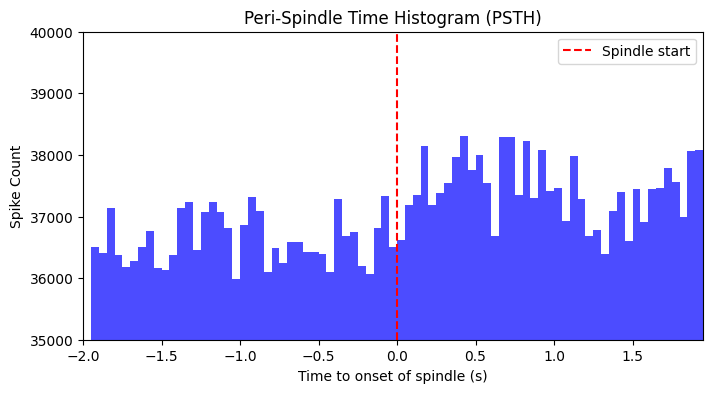

In [111]:
#PSTH

# Example data
spike_counts = psh_spindle[2]  # Your spikes per bin
bin_edges = np.linspace(-2, 2, 81)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Length: 80

# Plot PSTH
plt.figure(figsize=(8, 4))
plt.bar(bin_centers, spike_counts, width=0.05, align='center', color='blue', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', label='Spindle start')  # Optional: Mark stimulus time
plt.title("Peri-Spindle Time Histogram (PSTH)")
plt.xlabel("Time to onset of spindle (s)")
plt.ylabel("Spike Count")
plt.xlim(-2, 1.95)
plt.ylim(35000, 40000)
#plt.ylim(8000, 10000)
plt.legend()
plt.show()


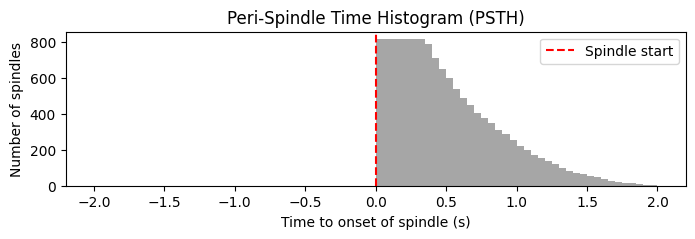

In [112]:
#PSTH

# Example data
spike_counts = psh_spindle[1]  # Your spikes per bin
bin_edges = np.linspace(-2, 2, 81)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Length: 80

# Plot PSTH
plt.figure(figsize=(8, 2))
plt.bar(bin_centers, spike_counts, width=0.05, align='center', color='grey', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', label='Spindle start')  # Optional: Mark stimulus time
plt.title("Peri-Spindle Time Histogram (PSTH)")
plt.xlabel("Time to onset of spindle (s)")
plt.ylabel("Number of spindles")
#plt.ylim(25000, 27000)
plt.legend()
plt.show()


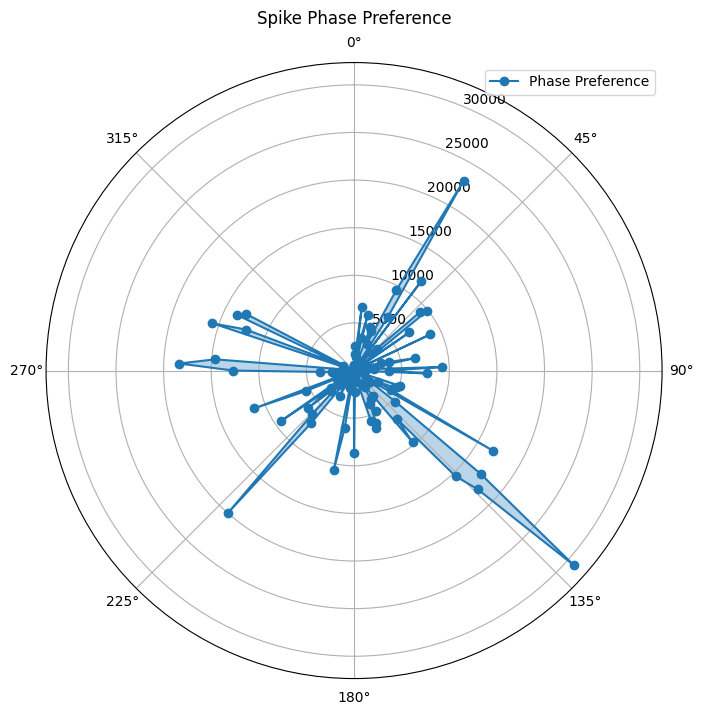

In [113]:
# Example data: Number of spikes per 1/12 of the cycle
spike_counts = np.sum(phase_prefs[:, 1:13], axis=1)  # Your actual data

# Define the phase angles (12 bins = 12 angles in radians)
angles = np.linspace(0, 2 * np.pi, len(spike_counts) + 1)  # Close the circle

# Repeat the first spike count at the end to close the circle
spike_counts = np.append(spike_counts, spike_counts[0])

# Create a polar plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Plot the data
ax.plot(angles, spike_counts, linestyle='-', marker='o', label="Phase Preference")
ax.fill(angles, spike_counts, alpha=0.3)  # Optional: Add shading

# Add labels
ax.set_theta_zero_location('N')  # Set 0 phase at the top
ax.set_theta_direction(-1)  # Set counterclockwise direction
ax.set_title("Spike Phase Preference", va='bottom')

# Add a legend
ax.legend(loc='upper right')

plt.show()


C:\Users\Manip1\AppData\Local\Temp\ipykernel_8624\2002746094.py:6: RuntimeWarning: invalid value encountered in divide
  normalized_phase_prefs[x,1:] /= np.mean(phase_prefs[x,1:])


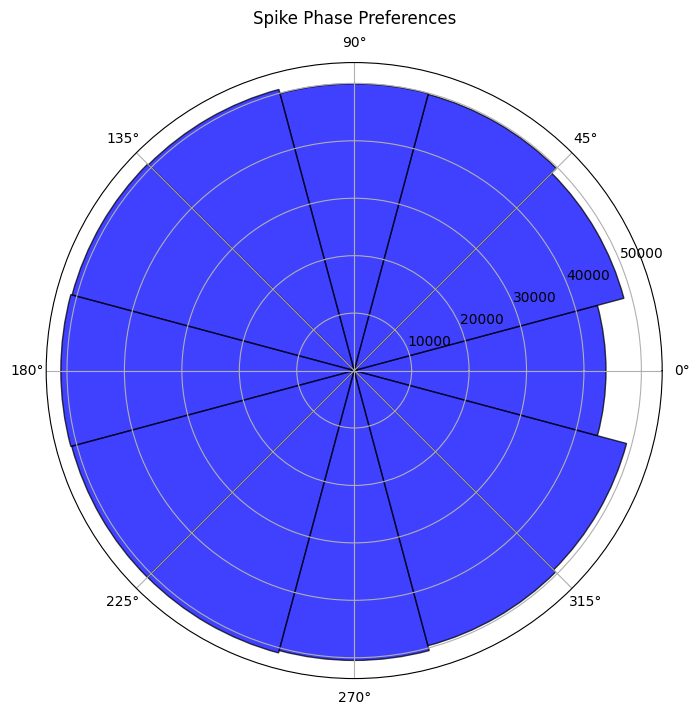

In [114]:
# Example: Replace this with your actual spike counts for each bin
# For example, spike_counts could be the number of spikes in each 1/12 of the cycle
spike_counts = np.sum(phase_prefs[:,1:13], axis=0)  # Your actual data
normalized_phase_prefs = np.copy(phase_prefs)
for x in range(len(normalized_phase_prefs)):
    normalized_phase_prefs[x,1:] /= np.mean(phase_prefs[x,1:])
normalized_spike_counts = np.mean(normalized_phase_prefs[:,1:13], axis=0)


# Define the number of bins (12 sections for 1/12 of cycle)
num_bins = 12

# Create the rose plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Define bin edges (assuming a full circle: 0 to 2*pi radians, divided into 12 bins)
theta = np.linspace(0, 2*np.pi, num_bins+1)  # Create bin edges

# Plot the spike counts as bars on a circular plot
ax.bar(theta[:-1], spike_counts, width=theta[1]-theta[0], bottom=0, color='blue', edgecolor='black', alpha=0.75)

# Set the title of the plot
ax.set_title('Spike Phase Preferences', va='bottom')

# Show the plot
plt.show()


In [201]:
np.mean(normalized_phase_prefs[:,1:13], axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.])

In [183]:
np.mean(phase_prefs[x,1:])

300.6666666666667

In [178]:
normalized_phase_prefs

array([[  1.        ,   0.99893276,   1.00747065, ...,   0.99893276,
          1.09284952,   0.96905016],
       [  2.        ,   0.96532121,   1.07447413, ...,   1.06083002,
          0.83911313,   0.96873223],
       [  3.        ,   0.95896328,   0.92440605, ...,   1.0237581 ,
          1.02807775,   1.03239741],
       ...,
       [292.        ,   0.85760693,   0.97455333, ...,   0.98105035,
          1.03302653,   1.01353546],
       [294.        ,   0.8854253 ,   1.01475709, ...,   1.03067485,
          1.00082905,   1.01674681],
       [297.        ,   0.92519347,   1.05760963, ...,   0.9905417 ,
          1.05760963,   1.04041273]])

### Extract relevant variables from recordings

In [2]:
#Variables that might change from mouse to mouse

# format: recordings = [date_time, TTL of midline, TTL of VB]       #put float("nan") if no stim of this type in recording!!
recordings = [["2023-11-14_15-45-09", 1, 2], ["2023-11-15_14-00-12", float("nan"), 1], ["2023-11-16_13-47-23", 1, 2], ["2024-01-23_11-42-06", 2, float("nan")]]
# format: CA1_Eles = [CA1 ipsi, CA1 contra]
CA1_Eles = [7, 14]
stim_regions = ["mid", "vb"]    #make sure to have that in same order as TTLs in recordings info
Letter = "I:"
nb_E = 15
mouse = os.path.basename(os.getcwd())   #script contained in folder named after mouse

#Plenty of empty lists that will be filled with variables
EMGboolean = []
EMGs = []
CA1_i = []
CA1_c = []
CA1_i_cwt = []
CA1_c_cwt = []
CA1_i_means_sd = []
CA1_c_means_sd = []
CA1_i_stim0 = []
CA1_c_stim0 = []
CA1_i_onlystim = []
CA1_c_onlystim = []


for rec_nb, rec_infos in enumerate(recordings):
    print(rec_infos)
    date_time = rec_infos[0]
    if date_time == "2024-01-23_11-42-06":
        recordnode = 101
        acquiboard = 100
    else:
        recordnode = 105
        acquiboard = 104


    ### STIM TIMES ###
    #Load stim info from hard drive with original recording
    sample_numbers = np.load(f"{Letter}/{date_time}/Record Node {recordnode}/experiment1/recording1/events/Acquisition_Board-{acquiboard}.Rhythm Data/TTL/sample_numbers.npy")
    channel_states = np.load(f"{Letter}/{date_time}/Record Node {recordnode}/experiment1/recording1/events/Acquisition_Board-{acquiboard}.Rhythm Data/TTL/states.npy")
    cont = np.load(f"{Letter}/{date_time}/Record Node {recordnode}/experiment1/recording1/continuous/Acquisition_Board-{acquiboard}.Rhythm Data/sample_numbers.npy")

    for pos, stim_region in enumerate(stim_regions):
        TTL = rec_infos[pos+1]  #because loops through mid then vb, and info about TTL is in position 1 and 2 of sub-list in "recordings" (line 4)
        
        if TTL == float("nan"):
            globals()[f"stim_times_{stim_region}_rec{rec_nb}"] = float("nan")

        else:
            # find the indices of the start and end times
            start_indices = np.where(channel_states == TTL)[0]
            end_indices = np.where(channel_states == -TTL)[0]

            # create a new array with the start and end times
            stim_times = np.zeros((len(start_indices), 2))
            for i in range(len(start_indices)):
                stim_times[i, 0] = sample_numbers[start_indices[i]]
                stim_times[i, 1] = sample_numbers[end_indices[i]]

            #Adjust stim timestamps - start time and sampling frequency
            start_time = cont[0]  # in 0.5 milliseconds   #First value of timestamps memmap from 'continuous' folder
            stim_times -= start_time
            stim_times = stim_times.astype('float64')
            stim_times /= 2.0
            stim_times = stim_times.astype('int64')

            #Identify stim_times by name of stimulated region, keep only that
            globals()[f"stim_times_{stim_region}_rec{rec_nb}"] = stim_times; stim_times = None



    ### LFP RECORDINGS ###
    # Load DS and ordered recordings, and sleep scoring frame, from subfolder
    EMGboolean.append(pd.read_pickle(f'{date_time}/EMGframeBoolean_1.pkl'))
    All = np.load(f'{date_time}/RawDataChannelExtractedDS_1.npy', mmap_mode= 'r')

    #Get LFPs by calculating differences between electrode pairs
    EMG = All[:,0]
    y = 1
    for x in range(nb_E):
        exec(f"Ea = All[:,{y}]")
        y += 1
        exec(f"Eb = All[:,{y}]")
        y += 1
        exec(f"E{x} = Ea - Eb")

    #Keep only CA1 channels, erase the rest
    exec(f"CA1_i.append(E{CA1_Eles[0]})")
    exec(f"CA1_c.append(E{CA1_Eles[1]})")

    # Filter EMG for nicer visualisation later on
    f_lowcut = 200.; f_hicut = 400.; N = 4; fs = 1000; nyq = 0.5 * fs
    Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction
    b, a = signal.butter(N, Wn, 'band')
    filt_EMG = signal.filtfilt(b, a, EMG)
    EMGs.append(filt_EMG)
    
    All = None; Ea = None; Eb = None
    for x in range(nb_E):
        exec(f"E{x} = None")
#Gathered all info from recordings, now end loop
    

### ANALYSE CA1 LFPs ###
# Contiuous wavelet transform (parameters and computation)
w = 10.
fs = 1000
freq = np.linspace(120, 200, 80)
widths = w*fs / (2*freq*np.pi)

for rec_nb in range(len(recordings)):
    CA1_i_cwt.append(np.mean(np.absolute(signal.cwt(CA1_i[rec_nb], signal.morlet2, widths, w=w)), axis=0))
    CA1_c_cwt.append(np.mean(np.absolute(signal.cwt(CA1_c[rec_nb], signal.morlet2, widths, w=w)), axis=0))

# From the whole recording, keep only times where there is a stimulation (with some time before and after) that entirely happens during sleep
for hemi in ["i", "c"]:
    for rec_nb in range(len(recordings)):
        CWT_wakeremoved = np.array(globals()[f"CA1_{hemi}_cwt"][rec_nb].copy())
        CWT_wakeremoved = CWT_wakeremoved[EMGboolean[rec_nb]['BooleanLiberal']]  #Keep only SWS
        CA1_mean = np.mean(CWT_wakeremoved)
        CA1_sd = np.std(CWT_wakeremoved)
        globals()[f"CA1_{hemi}_means_sd"].append([CA1_mean, CA1_sd])
        CWT_stim0 = np.array(globals()[f"CA1_{hemi}_cwt"][rec_nb].copy())
        CWT_stim0[~EMGboolean[rec_nb]['BooleanLiberal']] = 0  #Put everything else than SWS to 0

        stimtimes_vector = np.zeros(len(CWT_stim0))
        for stim_region in stim_regions:
            stim_times = globals()[f"stim_times_{stim_region}_rec{rec_nb}"]
            for stim_nb in range(0, len(stim_times), 10):   #every 10th stim because blocks of 10
                stim_start = stim_times[stim_nb, 0]
                stim_end = stim_times[stim_nb+9, 1]
                stim_duration = stim_end-stim_start

                # Marquer la période de stimulation dans le vecteur
                stim_window = slice(stim_start - stim_duration, stim_end + stim_duration + 10000)
                stimtimes_vector[stim_window] = 1

                # Vérifier si au moins une valeur dans la fenêtre de stimulation n'est pas contenue dans EMGboolean-sommeil
                if np.any(~EMGboolean[rec_nb]['BooleanLiberal'][stim_window]):
                    stimtimes_vector[stim_window] = 0

            # # Exclure les périodes marquées par EMGboolean
            stimtimes_vector[~EMGboolean[rec_nb]['BooleanLiberal']] = 0
            tests.append(stimtimes_vector)

        # Créer un vecteur booléen pour les périodes de stimulation
        bool_stimtimes = (stimtimes_vector == 1)
        CWT_stim0[~bool_stimtimes] = 0   #now also put everything that is not before/during/after stim to 0
        globals()[f"CA1_{hemi}_stim0"].append(CWT_stim0)
        times = np.arange(len(CWT_stim0))[bool_stimtimes]
        CWT_onlystim = np.concatenate((CWT_stim0[bool_stimtimes], times)).reshape(2,len(times)) #create variable where everything except valid stimtimes is removed, but add times row to preserve info about original times
        globals()[f"CA1_{hemi}_onlystim"].append(CWT_onlystim)
        globals()[f"bool_stimtimes_rec{rec_nb}"] = bool_stimtimes

CWT_wakeremoved = None #free memory

['2023-11-14_15-45-09', 1, 2]
['2023-11-15_14-00-12', nan, 1]
['2023-11-16_13-47-23', 1, 2]
['2024-01-23_11-42-06', 2, nan]


### Detect SWRs

#### Recording 0

In [3]:
### REC 0 ###

### DETECT SWRs ON STIM ONLY DATA ###
#Do both hemispheres (can view both at same time)
for hemi in ["i", "c"]:
    if hemi == "i":
        threshold = 4   #number by which to multiply SD; 2 diff thresholds for 2 diff channels
    else:
        threshold = 4
    
    CA1_mean = globals()[f"CA1_{hemi}_means_sd"][0][0]
    CA1_sd = globals()[f"CA1_{hemi}_means_sd"][0][1]
    peaks, properties = find_peaks(globals()[f"CA1_{hemi}_onlystim"][0][0], prominence=1, width=20, height = CA1_mean+CA1_sd*threshold)

    properties["prominences"], properties["widths"]
    # SWR boundaries taken at 70% from peak of intensity. This means that the SWRs with small amplitude will be longer than the big ones.
    results_width = peak_widths(globals()[f"CA1_{hemi}_onlystim"][0][0], peaks, rel_height=0.7)
    peaks2 = peaks.reshape(len(peaks),1)
    npresults_width = np.array(results_width).reshape(4,-1)
    SWR_prop = np.append(peaks2, results_width).reshape(5,len(peaks2)).round()

    #Filter signal because is nice for SWR visualisation
    f_lowcut = 120.; f_hicut = 200.; fs = 1000; nyq = 0.5 * fs; N = 6
    Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction
    b, a = signal.butter(N, Wn, 'band')
    globals()[f"filt_CA1_{hemi}"] = signal.filtfilt(b, a, globals()[f"CA1_{hemi}"][0])
    globals()[f"peaks_{hemi}_rec0"] = peaks
    globals()[f"SWR_prop_{hemi}"] = SWR_prop



### LOOK AT THE RESULT AND JUDGE IT; UPDATE THRESHOLD AND REPEAT IF NECESSARY ###
app = mkQApp()

sample_rate = 1000.
t_start = 0.

combined = np.stack([CA1_i[0][bool_stimtimes_rec0], CA1_i_onlystim[0][0], filt_CA1_i[bool_stimtimes_rec0], CA1_c[0][bool_stimtimes_rec0], CA1_c_onlystim[0][0], filt_CA1_c[bool_stimtimes_rec0], EMGs[0][bool_stimtimes_rec0]], axis = 1)

#create 2 family scatters from theses 2 indexes
scatter_indexes = {0: peaks_i_rec0, 1: peaks_c_rec0}
#and assign them to some channels each
scatter_channels = {0: [0, 1], 1: [3, 4]}

source = AnalogSignalSourceWithScatter(combined, sample_rate, t_start, scatter_indexes, scatter_channels)

#Create the main window that can contain several viewers
win = MainViewer(debug=True, show_auto_scale=True)

#create a viewer for signal with TraceViewer
#connected to the signal source
view1 = TraceViewer(source=source)

#Parameters can be set in script
#view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
#And also parameters for each channel
view1.by_channel_params['ch0', 'color'] = '#ffffff'
view1.by_channel_params['ch1', 'color'] = '#0055ff'
view1.by_channel_params['ch2', 'color'] = '#ff5500'
view1.by_channel_params['ch3', 'color'] = '#ffffff'
view1.by_channel_params['ch4', 'color'] = '#0055ff'
view1.by_channel_params['ch5', 'color'] = '#ff5500'
view1.by_channel_params['ch6', 'color'] = 'red'

view1.by_channel_params['ch0', 'gain'] = 0.0005
view1.by_channel_params['ch1', 'gain'] = 0.0015
view1.by_channel_params['ch2', 'gain'] = 0.0015
view1.by_channel_params['ch3', 'gain'] = 0.001
view1.by_channel_params['ch4', 'gain'] = 0.0015
view1.by_channel_params['ch5', 'gain'] = 0.0015
view1.by_channel_params['ch6', 'gain'] = 0.001

view1.by_channel_params['ch0', 'offset'] = 4
view1.by_channel_params['ch1', 'offset'] = 1
view1.by_channel_params['ch2', 'offset'] = 1
view1.by_channel_params['ch3', 'offset'] = -3
view1.by_channel_params['ch4', 'offset'] = -6
view1.by_channel_params['ch5', 'offset'] = -6
view1.by_channel_params['ch6', 'offset'] = 8

#put this viewer in the main window
win.add_view(view1)

#Run
win.show()
app.exec()

print(len(CA1_i_onlystim[0][0]))
print(len(peaks_i_rec0), len(peaks_c_rec0))

debug True
QT_MODE PySide6
refresh duration for  0.0009975433349609375 s
save_all_settings
3107099
1627 1910


#### Recording 1

In [4]:
### REC 1 ###

### DETECT SWRs ON STIM ONLY DATA ###
#Do both hemispheres (can view both at same time) but only one recording at a time
for hemi in ["i", "c"]:
    if hemi == "i":
        threshold = 4   #number by which to multiply SD; 2 diff thresholds for 2 diff channels
    else:
        threshold = 4
    
    CA1_mean = globals()[f"CA1_{hemi}_means_sd"][1][0]
    CA1_sd = globals()[f"CA1_{hemi}_means_sd"][1][1]
    peaks, properties = find_peaks(globals()[f"CA1_{hemi}_onlystim"][1][0], prominence=1, width=20, height = CA1_mean+CA1_sd*threshold)

    properties["prominences"], properties["widths"]
    # SWR boundaries taken at 70% from peak of intensity. This means that the SWRs with small amplitude will be longer than the big ones.
    results_width = peak_widths(globals()[f"CA1_{hemi}_onlystim"][1][0], peaks, rel_height=0.7)
    peaks2 = peaks.reshape(len(peaks),1)
    npresults_width = np.array(results_width).reshape(4,-1)
    SWR_prop = np.append(peaks2, results_width).reshape(5,len(peaks2)).round()

    #Filter signal because is nice for SWR visualisation
    f_lowcut = 120.; f_hicut = 200.; fs = 1000; nyq = 0.5 * fs; N = 6
    Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction
    b, a = signal.butter(N, Wn, 'band')
    globals()[f"filt_CA1_{hemi}"] = signal.filtfilt(b, a, globals()[f"CA1_{hemi}"][1])
    globals()[f"peaks_{hemi}_rec1"] = peaks
    globals()[f"SWR_prop_{hemi}"] = SWR_prop



### LOOK AT THE RESULT AND JUDGE IT; REPEAT IF NECESSARY ###
app = mkQApp()

sample_rate = 1000.
t_start = 0.

combined = np.stack([CA1_i[1][bool_stimtimes_rec1], CA1_i_onlystim[1][0], filt_CA1_i[bool_stimtimes_rec1], CA1_c[1][bool_stimtimes_rec1], CA1_c_onlystim[1][0], filt_CA1_c[bool_stimtimes_rec1], EMGs[1][bool_stimtimes_rec1]], axis = 1)

#create 2 family scatters from theses 2 indexes
scatter_indexes = {0: peaks_i_rec1, 1: peaks_c_rec1}
#and assign them to some channels each
scatter_channels = {0: [0, 1], 1: [3, 4]}

source = AnalogSignalSourceWithScatter(combined, sample_rate, t_start, scatter_indexes, scatter_channels)

#Create the main window that can contain several viewers
win = MainViewer(debug=True, show_auto_scale=True)

#create a viewer for signal with TraceViewer
#connected to the signal source
view1 = TraceViewer(source=source)

#Parameters can be set in script
#view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
#And also parameters for each channel
view1.by_channel_params['ch0', 'color'] = '#ffffff'
view1.by_channel_params['ch1', 'color'] = '#0055ff'
view1.by_channel_params['ch2', 'color'] = '#ff5500'
view1.by_channel_params['ch3', 'color'] = '#ffffff'
view1.by_channel_params['ch4', 'color'] = '#0055ff'
view1.by_channel_params['ch5', 'color'] = '#ff5500'
view1.by_channel_params['ch6', 'color'] = 'red'

view1.by_channel_params['ch0', 'gain'] = 0.0005
view1.by_channel_params['ch1', 'gain'] = 0.002
view1.by_channel_params['ch2', 'gain'] = 0.002
view1.by_channel_params['ch3', 'gain'] = 0.001
view1.by_channel_params['ch4', 'gain'] = 0.002
view1.by_channel_params['ch5', 'gain'] = 0.002
view1.by_channel_params['ch6', 'gain'] = 0.001

view1.by_channel_params['ch0', 'offset'] = 4
view1.by_channel_params['ch1', 'offset'] = 1
view1.by_channel_params['ch2', 'offset'] = 1
view1.by_channel_params['ch3', 'offset'] = -3
view1.by_channel_params['ch4', 'offset'] = -6
view1.by_channel_params['ch5', 'offset'] = -6
view1.by_channel_params['ch6', 'offset'] = 8

#put this viewer in the main window
win.add_view(view1)

#Run
win.show()
app.exec()

print(len(CA1_i_onlystim[1][0]))
print(len(peaks_i_rec1), len(peaks_c_rec1))

debug True
QT_MODE PySide6
refresh duration for  0.0 s
save_all_settings
2571182
1310 1496


#### Recording 2

In [5]:
### REC 2 ###

### DETECT SWRs ON STIM ONLY DATA ###
#Do both hemispheres (can view both at same time) but only one recording at a time
for hemi in ["i", "c"]:
    if hemi == "i":
        threshold = 4   #number by which to multiply SD; 2 diff thresholds for 2 diff channels
    else:
        threshold = 4
    
    CA1_mean = globals()[f"CA1_{hemi}_means_sd"][2][0]
    CA1_sd = globals()[f"CA1_{hemi}_means_sd"][2][1]
    peaks, properties = find_peaks(globals()[f"CA1_{hemi}_onlystim"][2][0], prominence=1, width=20, height = CA1_mean+CA1_sd*threshold)

    properties["prominences"], properties["widths"]
    # SWR boundaries taken at 70% from peak of intensity. This means that the SWRs with small amplitude will be longer than the big ones.
    results_width = peak_widths(globals()[f"CA1_{hemi}_onlystim"][2][0], peaks, rel_height=0.7)
    peaks2 = peaks.reshape(len(peaks),1)
    npresults_width = np.array(results_width).reshape(4,-1)
    SWR_prop = np.append(peaks2, results_width).reshape(5,len(peaks2)).round()

    #Filter signal because is nice for SWR visualisation
    f_lowcut = 120.; f_hicut = 200.; fs = 1000; nyq = 0.5 * fs; N = 6
    Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction
    b, a = signal.butter(N, Wn, 'band')
    globals()[f"filt_CA1_{hemi}"] = signal.filtfilt(b, a, globals()[f"CA1_{hemi}"][2])
    globals()[f"peaks_{hemi}_rec2"] = peaks
    globals()[f"SWR_prop_{hemi}"] = SWR_prop



### LOOK AT THE RESULT AND JUDGE IT; REPEAT IF NECESSARY ###
app = mkQApp()

sample_rate = 1000.
t_start = 0.

combined = np.stack([CA1_i[2][bool_stimtimes_rec2], CA1_i_onlystim[2][0], filt_CA1_i[bool_stimtimes_rec2], CA1_c[2][bool_stimtimes_rec2], CA1_c_onlystim[2][0], filt_CA1_c[bool_stimtimes_rec2], EMGs[2][bool_stimtimes_rec2]], axis = 1)

#create 2 family scatters from theses 2 indexes
scatter_indexes = {0: peaks_i_rec2, 1: peaks_c_rec2}
#and assign them to some channels each
scatter_channels = {0: [0, 1], 1: [3, 4]}

source = AnalogSignalSourceWithScatter(combined, sample_rate, t_start, scatter_indexes, scatter_channels)

#Create the main window that can contain several viewers
win = MainViewer(debug=True, show_auto_scale=True)

#create a viewer for signal with TraceViewer
#connected to the signal source
view1 = TraceViewer(source=source)

#Parameters can be set in script
#view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
#And also parameters for each channel
view1.by_channel_params['ch0', 'color'] = '#ffffff'
view1.by_channel_params['ch1', 'color'] = '#0055ff'
view1.by_channel_params['ch2', 'color'] = '#ff5500'
view1.by_channel_params['ch3', 'color'] = '#ffffff'
view1.by_channel_params['ch4', 'color'] = '#0055ff'
view1.by_channel_params['ch5', 'color'] = '#ff5500'
view1.by_channel_params['ch6', 'color'] = 'red'

view1.by_channel_params['ch0', 'gain'] = 0.0005
view1.by_channel_params['ch1', 'gain'] = 0.002
view1.by_channel_params['ch2', 'gain'] = 0.002
view1.by_channel_params['ch3', 'gain'] = 0.001
view1.by_channel_params['ch4', 'gain'] = 0.002
view1.by_channel_params['ch5', 'gain'] = 0.002
view1.by_channel_params['ch6', 'gain'] = 0.001

view1.by_channel_params['ch0', 'offset'] = 4
view1.by_channel_params['ch1', 'offset'] = 1
view1.by_channel_params['ch2', 'offset'] = 1
view1.by_channel_params['ch3', 'offset'] = -3
view1.by_channel_params['ch4', 'offset'] = -6
view1.by_channel_params['ch5', 'offset'] = -6
view1.by_channel_params['ch6', 'offset'] = 8

#put this viewer in the main window
win.add_view(view1)

#Run
win.show()
app.exec()

print(len(CA1_i_onlystim[2][0]))
print(len(peaks_i_rec2), len(peaks_c_rec2))

debug True
QT_MODE PySide6
refresh duration for  0.0 s
save_all_settings
3680040
1879 2179


#### Recording 3

In [6]:
### REC 3 ###

### DETECT SWRs ON STIM ONLY DATA ###
#Do both hemispheres (can view both at same time) but only one recording at a time
for hemi in ["i", "c"]:
    if hemi == "i":
        threshold = 4   #number by which to multiply SD; 2 diff thresholds for 2 diff channels
    else:
        threshold = 4
    
    CA1_mean = globals()[f"CA1_{hemi}_means_sd"][2][0]
    CA1_sd = globals()[f"CA1_{hemi}_means_sd"][2][1]
    peaks, properties = find_peaks(globals()[f"CA1_{hemi}_onlystim"][3][0], prominence=1, width=20, height = CA1_mean+CA1_sd*threshold)

    properties["prominences"], properties["widths"]
    # SWR boundaries taken at 70% from peak of intensity. This means that the SWRs with small amplitude will be longer than the big ones.
    results_width = peak_widths(globals()[f"CA1_{hemi}_onlystim"][3][0], peaks, rel_height=0.7)
    peaks2 = peaks.reshape(len(peaks),1)
    npresults_width = np.array(results_width).reshape(4,-1)
    SWR_prop = np.append(peaks2, results_width).reshape(5,len(peaks2)).round()

    #Filter signal because is nice for SWR visualisation
    f_lowcut = 120.; f_hicut = 200.; fs = 1000; nyq = 0.5 * fs; N = 6
    Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction
    b, a = signal.butter(N, Wn, 'band')
    globals()[f"filt_CA1_{hemi}"] = signal.filtfilt(b, a, globals()[f"CA1_{hemi}"][3])
    globals()[f"peaks_{hemi}_rec3"] = peaks
    globals()[f"SWR_prop_{hemi}"] = SWR_prop



### LOOK AT THE RESULT AND JUDGE IT; REPEAT IF NECESSARY ###
app = mkQApp()

sample_rate = 1000.
t_start = 0.

combined = np.stack([CA1_i[3][bool_stimtimes_rec3], CA1_i_onlystim[3][0], filt_CA1_i[bool_stimtimes_rec3], CA1_c[3][bool_stimtimes_rec3], CA1_c_onlystim[3][0], filt_CA1_c[bool_stimtimes_rec3], EMGs[3][bool_stimtimes_rec3]], axis = 1)

#create 2 family scatters from theses 2 indexes
scatter_indexes = {0: peaks_i_rec3, 1: peaks_c_rec3}
#and assign them to some channels each
scatter_channels = {0: [0, 1], 1: [3, 4]}

source = AnalogSignalSourceWithScatter(combined, sample_rate, t_start, scatter_indexes, scatter_channels)

#Create the main window that can contain several viewers
win = MainViewer(debug=True, show_auto_scale=True)

#create a viewer for signal with TraceViewer
#connected to the signal source
view1 = TraceViewer(source=source)

#Parameters can be set in script
#view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
#And also parameters for each channel
view1.by_channel_params['ch0', 'color'] = '#ffffff'
view1.by_channel_params['ch1', 'color'] = '#0055ff'
view1.by_channel_params['ch2', 'color'] = '#ff5500'
view1.by_channel_params['ch3', 'color'] = '#ffffff'
view1.by_channel_params['ch4', 'color'] = '#0055ff'
view1.by_channel_params['ch5', 'color'] = '#ff5500'
view1.by_channel_params['ch6', 'color'] = 'red'

view1.by_channel_params['ch0', 'gain'] = 0.0005
view1.by_channel_params['ch1', 'gain'] = 0.002
view1.by_channel_params['ch2', 'gain'] = 0.002
view1.by_channel_params['ch3', 'gain'] = 0.001
view1.by_channel_params['ch4', 'gain'] = 0.002
view1.by_channel_params['ch5', 'gain'] = 0.002
view1.by_channel_params['ch6', 'gain'] = 0.001

view1.by_channel_params['ch0', 'offset'] = 4
view1.by_channel_params['ch1', 'offset'] = 1
view1.by_channel_params['ch2', 'offset'] = 1
view1.by_channel_params['ch3', 'offset'] = -3
view1.by_channel_params['ch4', 'offset'] = -6
view1.by_channel_params['ch5', 'offset'] = -6
view1.by_channel_params['ch6', 'offset'] = 8

#put this viewer in the main window
win.add_view(view1)

#Run
win.show()
app.exec()

print(len(CA1_i_onlystim[3][0]))
print(len(peaks_i_rec3), len(peaks_c_rec3))

debug True
QT_MODE PySide6
refresh duration for  0.0 s
save_all_settings
1871881
944 1820


#### Remove bad events

### Count events in right bins

In [7]:
# THis will take all events from the peaks variables and place them in the correct bins: correct recording, hemisphere CA1, and stim freq

#When working with CA1_onlystim (shortened version of recording), times of events don't fit anymore, so to get back real times: value in peaks tuple = index of onlystim array; and at that index (last row) can be found time = index of realtime CA1

#Meaning of dimensions of event_count variables: (CA1 ipsi & contra; stim freqs 2-90 Hz; bins 5 before, 5 during, 5 after stim, & 10s after stim with 0.5s per bin)
event_count_mid = np.zeros((2, 13, 35))
event_count_vb = np.zeros((2, 13, 35))

all_stim_freq = (2,4,6,8,10,12,14,16,18,20,40,60,90)
total_count = 0


for stim_region in stim_regions:
    for rec_nb in range(len(recordings)):
        stim_times = globals()[f"stim_times_{stim_region}_rec{rec_nb}"]
        for f, stim_freq in enumerate(all_stim_freq):
            for stim_nb in range(0, len(stim_times), 10):   #every 10th stim because blocks of 10. To be optimised.
                stim_start = stim_times[stim_nb, 0]
                stim_duration = stim_times[stim_nb+9, 1] - stim_start
                bins = np.concatenate((np.arange(stim_start-stim_duration, stim_start+2*stim_duration, stim_duration/5), np.arange(stim_start+2*stim_duration, stim_start+2*stim_duration+10000, 500)))
                for h, hemi in enumerate(["i", "c"]): 
                    times_wrong = globals()[f"peaks_{hemi}_rec{rec_nb}"]
                    CA1_onlystim = globals()[f"CA1_{hemi}_onlystim"][rec_nb]
                    times = []
                    for t in times_wrong:
                        times.append(CA1_onlystim[1][t])

                    #Function created by ChatGPT
                    def find_bin_indices(bins, times):
                        times = np.array(times)
                        indices = np.searchsorted(bins, times, side='right') - 1
                        valid_indices = (indices >= 0) & (indices < len(bins) - 1)
                        indices = indices[valid_indices]
                        times = times[valid_indices]
                        in_bin = (times >= bins[indices]) & (times < bins[indices + 1])
                        result_indices = indices[in_bin]
                        return result_indices

                    bin_indices = find_bin_indices(bins, times)

                    #Append count only if stim we're looking at fits with stim freq in duration (with less precision necessary if high freq)
                    if stim_freq<30:
                        if round(9000/(stim_duration-20)) == stim_freq:
                            for b in bin_indices:
                                globals()[f"event_count_{stim_region}"][h, f, b] += 1
                            total_count += 1
                    else:
                        if round(9000/(stim_duration-20), -1) == stim_freq:
                            for b in bin_indices:
                                globals()[f"event_count_{stim_region}"][h, f, b] += 1
                            total_count +=1
                    #print(globals()[f"event_count_{stim_region}"][rec_nb])

Comments:
ipsi very good, but contra excellent. will pick contra

In [8]:
event_count_both = np.concatenate((event_count_mid, event_count_vb))
np.save(f"SWR count mouse{mouse} mid-vb.npy", event_count_both)

#format of numpy array:
#Meaning of dimensions: (CA1 ipsi & contra; stim freqs 2-90 Hz; bins 5 before, 5 during, 5 after stim, & 10s after stim with 0.5s per bin) (see above)
# and mid - CA1 ipsi contra; vb - CA1 ipsi contra


In [16]:
#Quick-check result

before = np.sum(event_count_mid[0, 5:9, :5])
during = np.sum(event_count_mid[0, 5:9, 5:10])
after = np.sum(event_count_mid[0, 5:9, 10:15])
after2 = np.sum(event_count_mid[0, 5:9, 16:17])
after3 = np.sum(event_count_mid[0, 5:9, 17:18])
after4 = np.sum(event_count_mid[0, 5:9, 18:19])
after5 = np.sum(event_count_mid[0, 5:9, 19:20])
after6 = np.sum(event_count_mid[0, 5:9, 20:21])
after7 = np.sum(event_count_mid[0, 5:9, 21:22])
after8 = np.sum(event_count_mid[0, 5:9, 22:23])

print(before, during, after, after2, after3, after4, after5, after6, after7, after8)

45.0 27.0 37.0 27.0 36.0 37.0 32.0 32.0 31.0 42.0


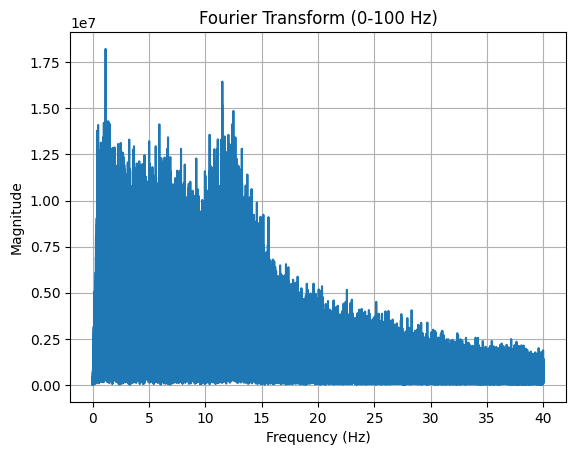

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Define sampling rate
sampling_rate = 1000  # Hz
N = len(Ele)  # Number of samples

# Compute Fourier Transform
fft_values = np.fft.fft(Ele)
frequencies = np.fft.fftfreq(N, d=1/sampling_rate)  # Frequency axis

# Keep only positive frequencies up to 100 Hz
positive_freqs = frequencies[:N//2]  # Keep only positive frequencies
positive_fft = np.abs(fft_values[:N//2])  # Magnitude spectrum

# Apply frequency filter
mask = positive_freqs <= 40  # Only keep frequencies ≤ 100 Hz

# Plot the magnitude spectrum
plt.plot(positive_freqs[mask], positive_fft[mask])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Fourier Transform (0-100 Hz)")
plt.grid()
plt.show()

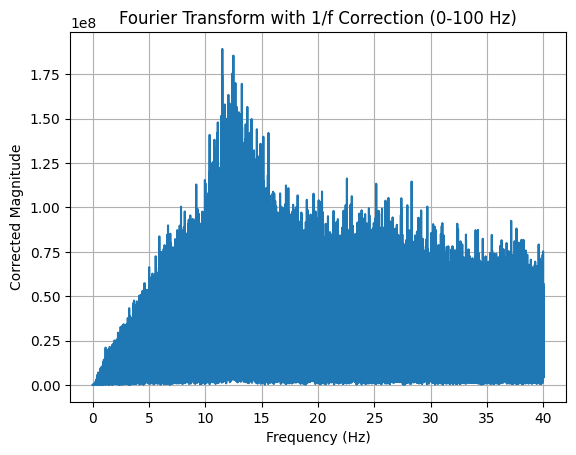

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Define sampling rate
sampling_rate = 1000  # Hz
N = len(Ele)  # Number of samples

# Compute Fourier Transform
fft_values = np.fft.fft(Ele)
frequencies = np.fft.fftfreq(N, d=1/sampling_rate)  # Frequency axis

# Keep only positive frequencies up to 100 Hz
positive_freqs = frequencies[:N//2]  # Keep only positive frequencies
positive_fft = np.abs(fft_values[:N//2])  # Magnitude spectrum

# Apply frequency filter
mask = (positive_freqs > 0) & (positive_freqs <= 40)  # Ignore DC (0 Hz) and keep up to 100 Hz

# Apply 1/f correction (avoid division by zero at DC component)
corrected_fft = positive_fft[mask] * positive_freqs[mask]

# Plot the corrected magnitude spectrum
plt.plot(positive_freqs[mask], corrected_fft)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Corrected Magnitude")
plt.title("Fourier Transform with 1/f Correction (0-100 Hz)")
plt.grid()
plt.show()
